In [90]:
import sys, os
from typing import Union 

import numpy as np
#read dicom with pydicom
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
sys.path.append(os.path.join(os.getcwd(), '../../'))
from ext.lab2im import utils
from SynthSeg.brain_generator import BrainGenerator

# import tensorflow as tf
# print(tf.__version__)  # Should print 2.2.0

# from tensorflow import keras
# print(keras.__version__)  # Should match tf.__version__.

DeepNeuro subject processing - experiment on CBE7

In [91]:

def calculate_ir_signal(
    A: float,
    PD: Union[np.ndarray, float], # Use Union for older Python
    TE: float,
    T2: Union[np.ndarray, float], # Use Union for older Python
    TI: float,
    T1: Union[np.ndarray, float], # Use Union for older Python
    TR: float,
    B1: Union[np.ndarray, float], # Use Union for older Python
    theta: float, # Inversion pulse nominal angle (in radians)
    alpha: float, # Excitation pulse nominal angle (in radians)
    epsilon: float = 1e-9 # Small value to prevent potential division by zero
) -> Union[np.ndarray, float]: # Use Union for older Python
   
    # Calculate angles affected by B1 inhomogeneity
    actual_theta = B1 * theta
    actual_alpha = B1 * alpha

    # Calculate exponential terms 
    # Adding epsilon prevents immediate division by zero if T1/T2 is exactly 0,
    # but negative T1/T2 can still cause issues (exp(positive) -> inf).
    E1 = np.exp(-TR / (T1 + epsilon))
    if TI == 0:
        E_TI = 0
    else:
        E_TI = np.exp(-TI / (T1 + epsilon))
    E2 = np.exp(-TE / (T2 + epsilon))

    # Calculate numerator and denominator
    cos_actual_theta = np.cos(actual_theta)
    numerator = 1.0 - (1.0 - cos_actual_theta) * E_TI - cos_actual_theta * E1

    cos_actual_alpha = np.cos(actual_alpha)
    denominator = 1.0 - cos_actual_alpha * cos_actual_theta * E1
    
    # --- NO MASKING - Direct Calculation ---
    # Note: If denominator is zero or near-zero, this will result in inf or NaN.
    # If T1 or T2 were negative, E1, E_TI or E2 might be inf, also leading to inf/NaN.
    signal = A * PD * E2 * (numerator / (denominator + epsilon)) # Add epsilon to final denom too

    return signal

In [92]:
qmri_data_dir = '/home/dual4090/lab/github/SynthSeg/output_example/test_qmri'

In [93]:
t1_paths = sorted(glob.glob(os.path.join(qmri_data_dir, 't1map*')))
t2_paths = sorted(glob.glob(os.path.join(qmri_data_dir, 't2map*')))
pd_paths = sorted(glob.glob(os.path.join(qmri_data_dir, 'pdmap*')))


assert len(t1_paths) == len(t2_paths) == len(pd_paths), "Number of T1, T2, and PD maps do not match"

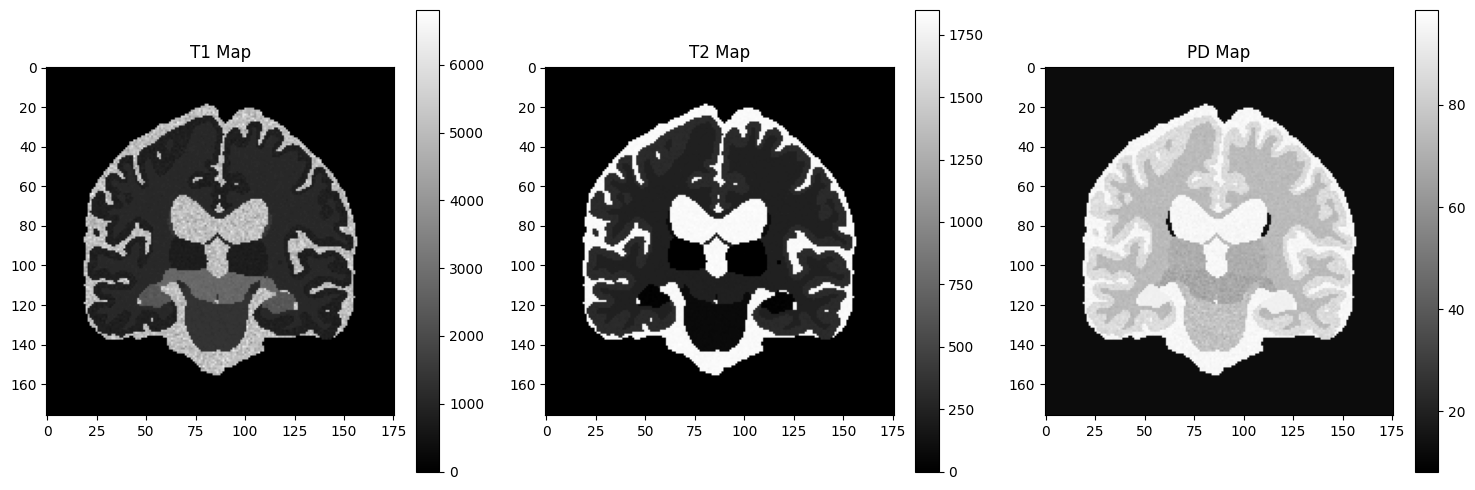

In [103]:
# subject_id = 
T1map = nib.load(t1_paths[0]).get_fdata()
T2map = nib.load(t2_paths[1]).get_fdata()
PDmap = nib.load(pd_paths[3]).get_fdata()
# Create a figure with 3 subplots side by side
plt.figure(figsize=(15, 5))

# Plot T1 map
plt.subplot(131)
plt.imshow(np.flipud(T1map[:,100,:].T), cmap='gray')
plt.title('T1 Map')
plt.colorbar()

# Plot T2 map 
plt.subplot(132)
plt.imshow(np.flipud(T2map[:,100,:].T), cmap='gray')
plt.title('T2 Map')
plt.colorbar()

# Plot PD map
plt.subplot(133)
plt.imshow(np.flipud(PDmap[:,100,:].T), cmap='gray')
plt.title('PD Map')
plt.colorbar()

plt.tight_layout()


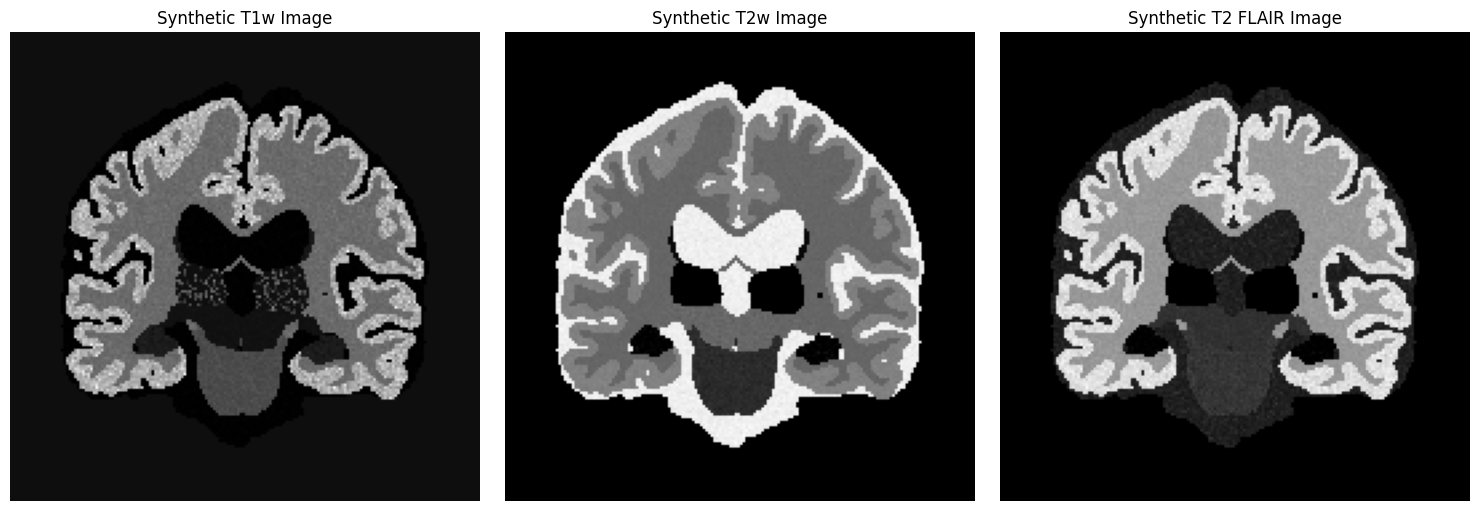

In [104]:
#simulate T1w image

T1_params = {
    'T1': T1map,
    'T2': T2map,
    'PD': PDmap,
    'A': 1.0,         # Scaling factor
    'TE': 2.604,       # Echo Time (ms)
    'TI': 1000.0,     # Inversion Time (ms)
    'TR': 2507.47,     # Repetition Time (ms)
    'B1': 1.0,        # Assume ideal B1 field
    'theta': np.pi,   # Ideal 180-degree inversion pulse
    'alpha': np.pi/2, # flip angle is 10 degrees
}

#simulate T2 image

T2_params = {
    'T1': T1map,
    'T2': T2map,
    'PD': PDmap,
    'A': 1.0,         # Scaling factor
    'TE': 97.084,       # Echo Time (ms)
    'TI': 0.0,     # Inversion Time (ms)
    'TR': 4890,     # Repetition Time (ms)
    'B1': 1.0,        # Assume ideal B1 field
    'theta': np.pi,   # Ideal 180-degree inversion pulse
    'alpha': np.pi*(180/115), # flip angle is 90 degrees
    # 'epsilon': 0
}

#simulate T2 FLAIR FSat image

FLAIR_params = {
    'T1': T1map,
    'T2': T2map,
    'PD': PDmap,
    'A': 1.0,         # Scaling factor
    'TE': 97.084,       # Echo Time (ms)
    'TI': 2200,     # Inversion Time (ms)
    'TR': 4890,     # Repetition Time (ms)
    'B1': 1.0,        # Assume ideal B1 field
    'theta': np.pi,   # Ideal 180-degree inversion pulse
    'alpha': np.pi/2, # flip angle is 90 degrees
}


# Calculate synthetic images
sT1w = calculate_ir_signal(**T1_params)
sT2w = calculate_ir_signal(**T2_params) 
sFLAIR = calculate_ir_signal(**FLAIR_params)

# Normalize each synthetic image to range [0,1]
sT1w = (sT1w - np.min(sT1w)) / (np.max(sT1w) - np.min(sT1w))
sT2w = (sT2w - np.min(sT2w)) / (np.max(sT2w) - np.min(sT2w))
sFLAIR = (sFLAIR - np.min(sFLAIR)) / (np.max(sFLAIR) - np.min(sFLAIR))


# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot T1w image
ax1.imshow(np.flipud(sT1w[:,100,:].T), cmap='gray')
ax1.set_title('Synthetic T1w Image')
ax1.axis('off')

# Plot T2w image
ax2.imshow(np.flipud(sT2w[:,100,:].T), cmap='gray')
ax2.set_title('Synthetic T2w Image')
ax2.axis('off')

# Plot FLAIR image
ax3.imshow(np.flipud(sFLAIR[:,100,:].T), cmap='gray')
ax3.set_title('Synthetic T2 FLAIR Image')
ax3.axis('off')

plt.tight_layout()
plt.show()

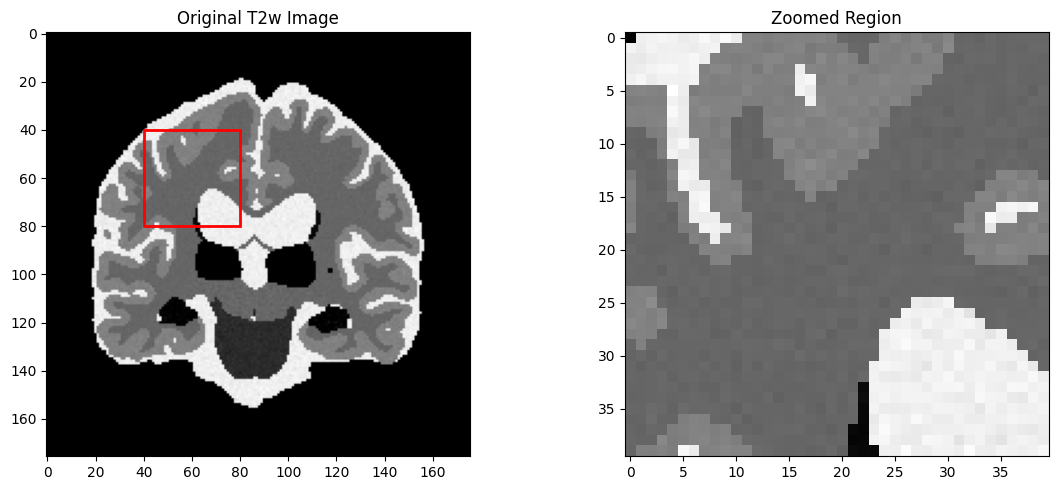

In [105]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot original image
ax1.imshow(np.flipud(sT2w[:,100,:].T), cmap='gray')
ax1.set_title('Original T2w Image')

# Define region to zoom (example coordinates - adjust as needed)
x1, x2 = 40, 80  # x coordinates
y1, y2 = 40, 80  # y coordinates

# Draw rectangle on original image
rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                    fill=False, color='red', linewidth=2)
ax1.add_patch(rect)

# # Extract and plot zoomed region
# zoomed = sT2w[:,100,:][y1:y2, x1:x2]  # Fixed indexing to match the displayed image
# ax2.imshow(np.flipud(zoomed.T), cmap='gray')
ax2.set_title('Zoomed Region')

# Update zoomed region display to match highlighted box
zoomed = np.flipud(sT2w[:,100,:].T)[x1:x2, y1:y2]  # Swap x and y coordinates to match display
ax2.imshow(zoomed, cmap='gray')
plt.tight_layout()
plt.show()

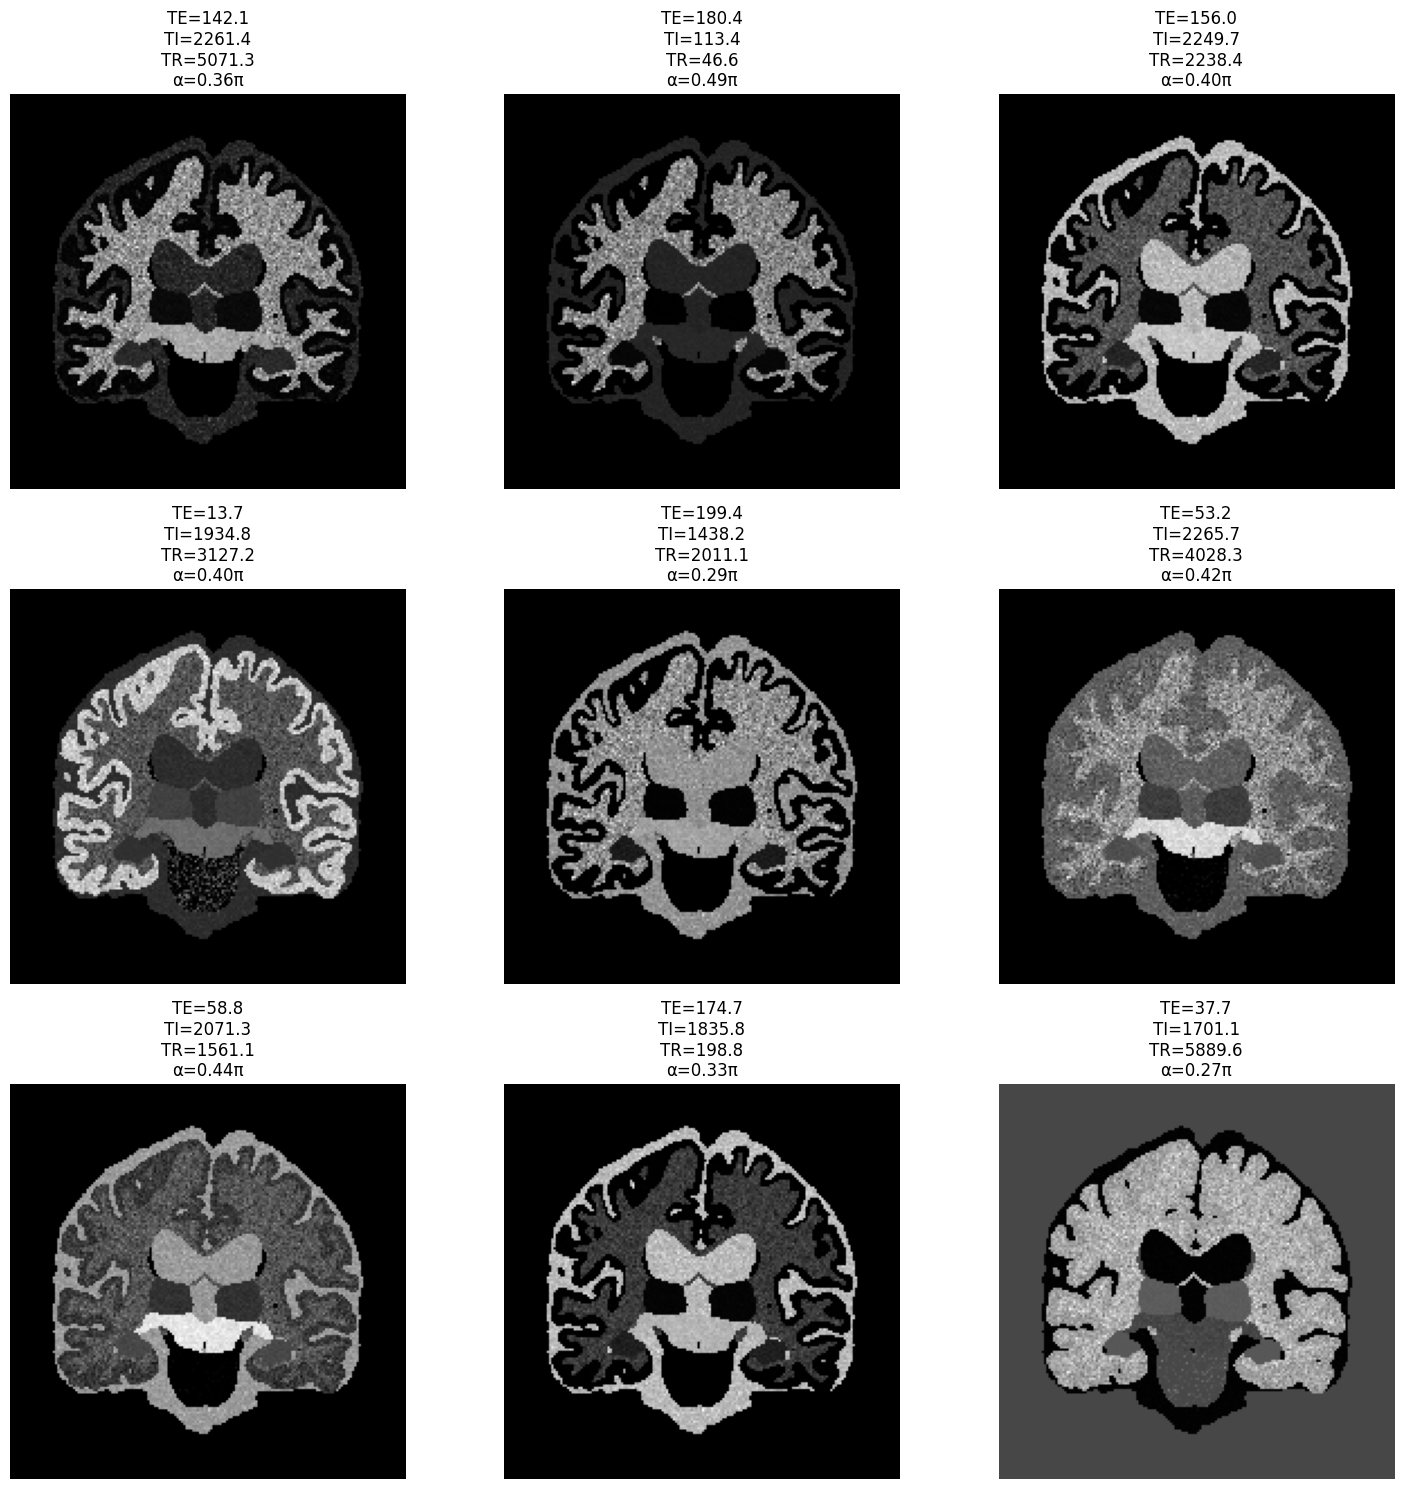

In [98]:
# Create figure with 9 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# Base parameters
base_params = FLAIR_params.copy()

# Parameter ranges for random sampling
param_ranges = {
    'TE': (0, 200),    # Echo time range in ms
    'TI': (0, 2600), # Inversion time range in ms  
    'TR': (0, 6000), # Repetition time range in ms
    'alpha': (np.pi/4, np.pi/2) # Flip angle range in radians
}

# Generate 9 random parameter combinations
for i in range(9):
    # Randomly sample parameters
    params = base_params.copy()
    params['TE'] = np.random.uniform(*param_ranges['TE'])
    params['TI'] = np.random.uniform(*param_ranges['TI'])
    params['TR'] = np.random.uniform(*param_ranges['TR'])
    params['alpha'] = np.random.uniform(*param_ranges['alpha'])
    
    # Calculate synthetic image
    synth_img = calculate_ir_signal(**params)
    
    # Normalize image
    synth_img = (synth_img - np.min(synth_img)) / (np.max(synth_img) - np.min(synth_img))
    
    # Plot image
    axes[i].imshow(np.flipud(synth_img[:,100,:].T), cmap='gray')
    axes[i].set_title(f'TE={params["TE"]:.1f}\nTI={params["TI"]:.1f}\nTR={params["TR"]:.1f}\nα={params["alpha"]/np.pi:.2f}π')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
# Save the figure
# plt.savefig('images/flair_parameter_variations.png', bbox_inches='tight', dpi=300)sT2w
